<a href="https://colab.research.google.com/github/dhambrick/kitsune-demo/blob/master/Kitsune_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/ymirsky/Kitsune-py.git

Cloning into 'Kitsune-py'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60
Unpacking objects: 100% (60/60), done.


In [0]:
%cd Kitsune-py/
!ls

[Errno 2] No such file or directory: 'Kitsune-py/'
/content/Kitsune-py
 AfterImage_NDSS.py    KitNET		    LICENSE	 sample_code_fig.png
 AfterImage.pyx        Kitsune_fig.png	    mirai.zip	 setup.py
 example.py	      'Kitsune paper.pdf'   netStat.py
 FeatureExtractor.py   Kitsune.py	    README.md


In [0]:
!python setup.py install
!apt-get install -y tshark
!pip install scapy


Compiling AfterImage.pyx because it changed.
[1/1] Cythonizing AfterImage.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Kitsune-py/AfterImage.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
running build
running build_ext
building 'AfterImage' extension
creating build
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c AfterImage.c -o build/temp.linux-x86_64-3.6/AfterImage.o
creating build/lib.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY

In [0]:
from Kitsune import Kitsune
import numpy as np
import time

Importing AfterImage Cython Library
Importing Scapy Library


In [0]:
print("Unzipping Sample Capture...")
import zipfile
with zipfile.ZipFile("mirai.zip","r") as zip_ref:
    zip_ref.extractall()

Unzipping Sample Capture...


In [0]:
# File location
path = "mirai.pcap" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

In [0]:
# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)


Parsing with tshark...
tshark parsing complete. File saved as: mirai.pcap.tsv
counting lines in file...
There are 764138 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode


In [0]:
print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))


Running Kitsune:
1000
2000
3000
4000
5000
The Feature-Mapper found a mapping: 100 features to 19 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
Feature-Mapper: execute-mode, Anomaly-Detector: execute-mode
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000

In [0]:
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:100000])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

Plotting results


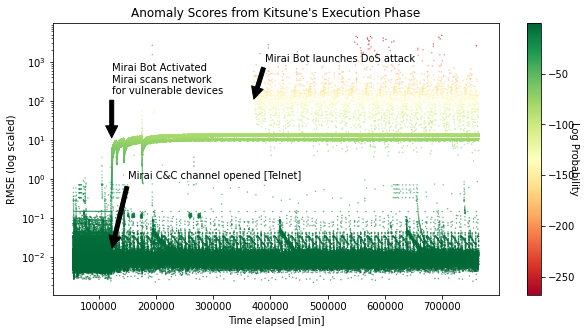

In [0]:
# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdYlGn')
plt.yscale("log")
plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
plt.annotate('Mirai C&C channel opened [Telnet]', xy=(121662,RMSEs[121662]), xytext=(151662,1),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.annotate('Mirai Bot Activated\nMirai scans network\nfor vulnerable devices', xy=(122662,10), xytext=(122662,150),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.annotate('Mirai Bot launches DoS attack', xy=(370000,100), xytext=(390000,1000),arrowprops=dict(facecolor='black', shrink=0.05),)
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270)
plt.show()